Welcome to this demonstration notebook for the Weather Classification Dataset and our trained models. This notebook provides an overview of the dataset, explores its structure, and showcases the performance of various models trained for weather classification.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from data_loading import download_dataset, WeatherDataModule, get_val_transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import seaborn as sns

/home/joscha/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Assuming download_dataset() is provided
dataset_path = "data/weather-dataset"
# download_dataset(dataset_path)
print(f"Dataset downloaded to: {dataset_path}")

# List dataset contents
classes = sorted(os.listdir(dataset_path))  # Sort for consistent ordering
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")
print("Classes:", classes)

# Count total images
num_images = sum(len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes)
print(f"Total Number of Images: {num_images}")

Dataset downloaded to: data/weather-dataset
Number of Classes: 11
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Total Number of Images: 6862


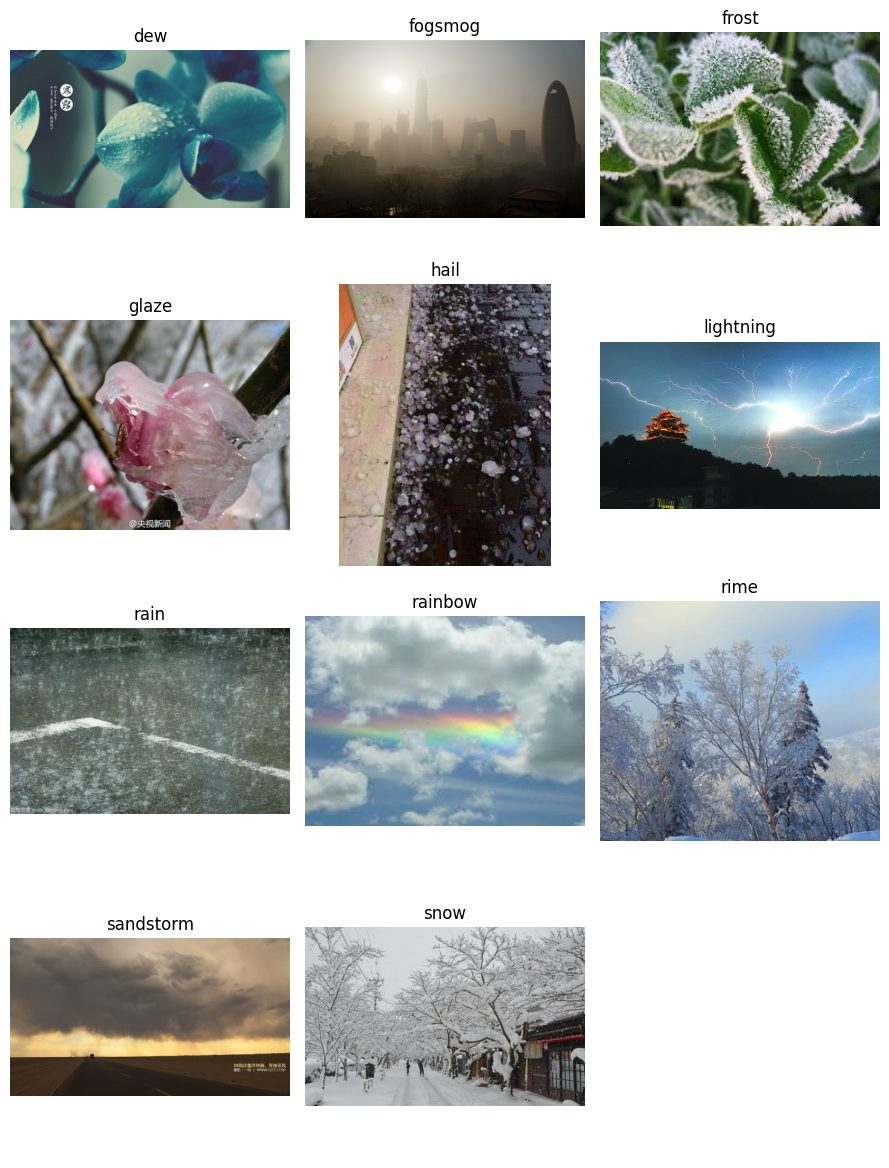

In [3]:
def show_samples(dataset_path, classes, images_per_row=3):
    num_classes = len(classes)
    rows = (num_classes + images_per_row - 1) // images_per_row
    
    fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3))
    axes = np.array(axes).reshape(-1)  # Flatten axes array for easier indexing

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        sample_image = np.random.choice(os.listdir(class_path), size=1)[0]
        
        img_path = os.path.join(class_path, sample_image)
        img = Image.open(img_path).convert("RGB")
        
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(cls, fontsize=12)
    
    # Hide unused subplots if number of classes is not a multiple of images_per_row
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

show_samples(dataset_path, classes, images_per_row=3)

As we can see in the following plot, the dataset has an uneven class distribution.
During training, this is handled using class weights to balance the impact of each class.


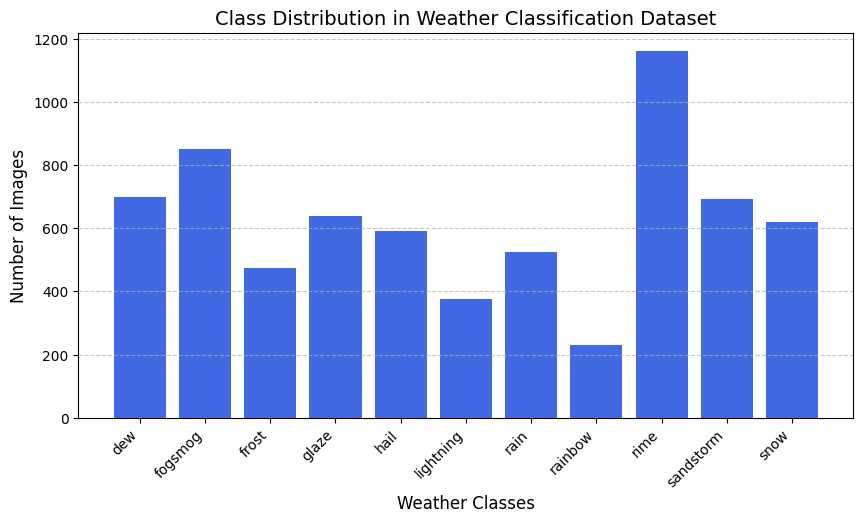

In [4]:
import matplotlib.pyplot as plt

# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Sort by class name (optional)
class_counts = dict(sorted(class_counts.items()))

# Print note about class imbalance
print("As we can see in the following plot, the dataset has an uneven class distribution.")
print("During training, this is handled using class weights to balance the impact of each class.")

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="royalblue")
plt.xlabel("Weather Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution in Weather Classification Dataset", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [5]:
# Dataset
datamodule = WeatherDataModule("./data/weather-dataset", 32, 1, get_val_transforms(), get_val_transforms())
datamodule.setup()
test_dataloader = datamodule.test_dataloader()
X_test = []
y_test = []
for images, labels in test_dataloader:
    X_test.append(images)
    y_test.append(labels)
X_test = torch.cat(X_test)
y_test = torch.cat(y_test)

In [6]:
import model as m
import torch

model_names = ["efficientnetb0", "efficientnetb1", "mobilenet", "resnet50", "swin"]
ckpt_paths = ["models/efficientnetb0-val_acc=0.93.ckpt", "models/efficientnetb1-val_acc=0.93.ckpt", "models/mobilenet-val_acc=0.90.ckpt", "models/resnet50-val_acc=0.91.ckpt", "models/swin-val_acc=0.94.ckpt"]
models = []
for model_name, ckpt_path in zip(model_names, ckpt_paths):
    model = m.get_base_model(model_name, 11)
    state_dict = torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict']
    for key in list(state_dict.keys()):
        state_dict[key.replace("model.", "")] = state_dict.pop(key)
    model.load_state_dict(state_dict,strict=False)
    models.append(model)

/tmp/ipykernel_9670/3935604271.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict']
/home/j

In [7]:
# Predictions
model_predictions = {}
X_test
for model_name, model in zip(model_names, models):
    print(f"Predicting using {model_name}...")
    model.to("cuda")
    model.eval()
    with torch.no_grad():
        model_predictions[model_name] = []
        for batch in X_test.split(32):
            y_pred = model(batch.to("cuda"))
            y_pred = y_pred.to("cpu")
            y_pred = torch.argmax(y_pred, dim=1)
            y_pred = y_pred.numpy()
            model_predictions[model_name].append(y_pred)
        model_predictions[model_name] = np.concatenate(model_predictions[model_name])
    model.to("cpu")
    torch.cuda.empty_cache()


Predicting using efficientnetb0...
Predicting using efficientnetb1...
Predicting using mobilenet...
Predicting using resnet50...
Predicting using swin...


In [8]:
# Dictionary containing predictions from different models
# Example: model_predictions = {"Model_1": y_pred_1, "Model_2": y_pred_2, ...}
model_scores = {}
y_true = y_test

for model_name, y_pred in model_predictions.items():
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    model_scores[model_name] = {"Accuracy": accuracy, "F1-Score": f1}


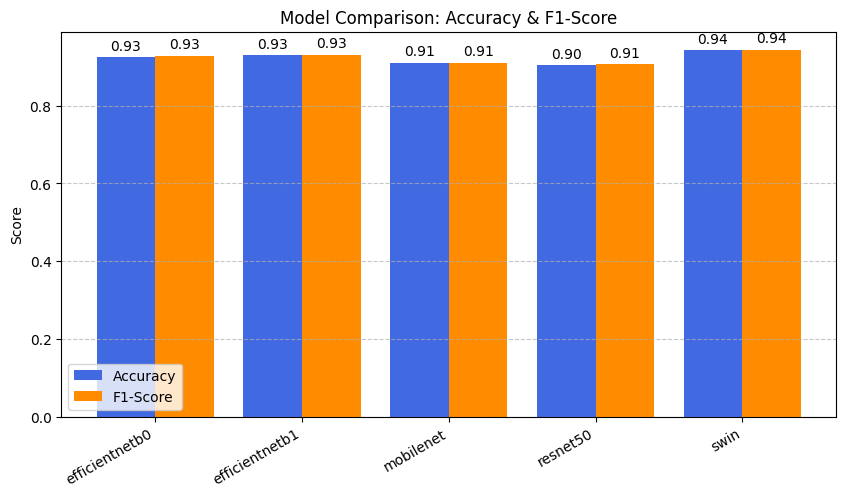

In [9]:
# Extract model names, accuracy, and F1-score
model_names = list(model_scores.keys())
accuracies = [model_scores[m]["Accuracy"] for m in model_names]
f1_scores = [model_scores[m]["F1-Score"] for m in model_names]

x = np.arange(len(model_names))  # X-axis positions

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
bars1 = plt.bar(x - bar_width / 2, accuracies, width=bar_width, label="Accuracy", color="royalblue")
bars2 = plt.bar(x + bar_width / 2, f1_scores, width=bar_width, label="F1-Score", color="darkorange")
plt.bar_label(bars1, fmt='%.2f', padding=3)
plt.bar_label(bars2, fmt='%.2f', padding=3)

plt.xticks(x, model_names, rotation=30, ha="right")
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy & F1-Score")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

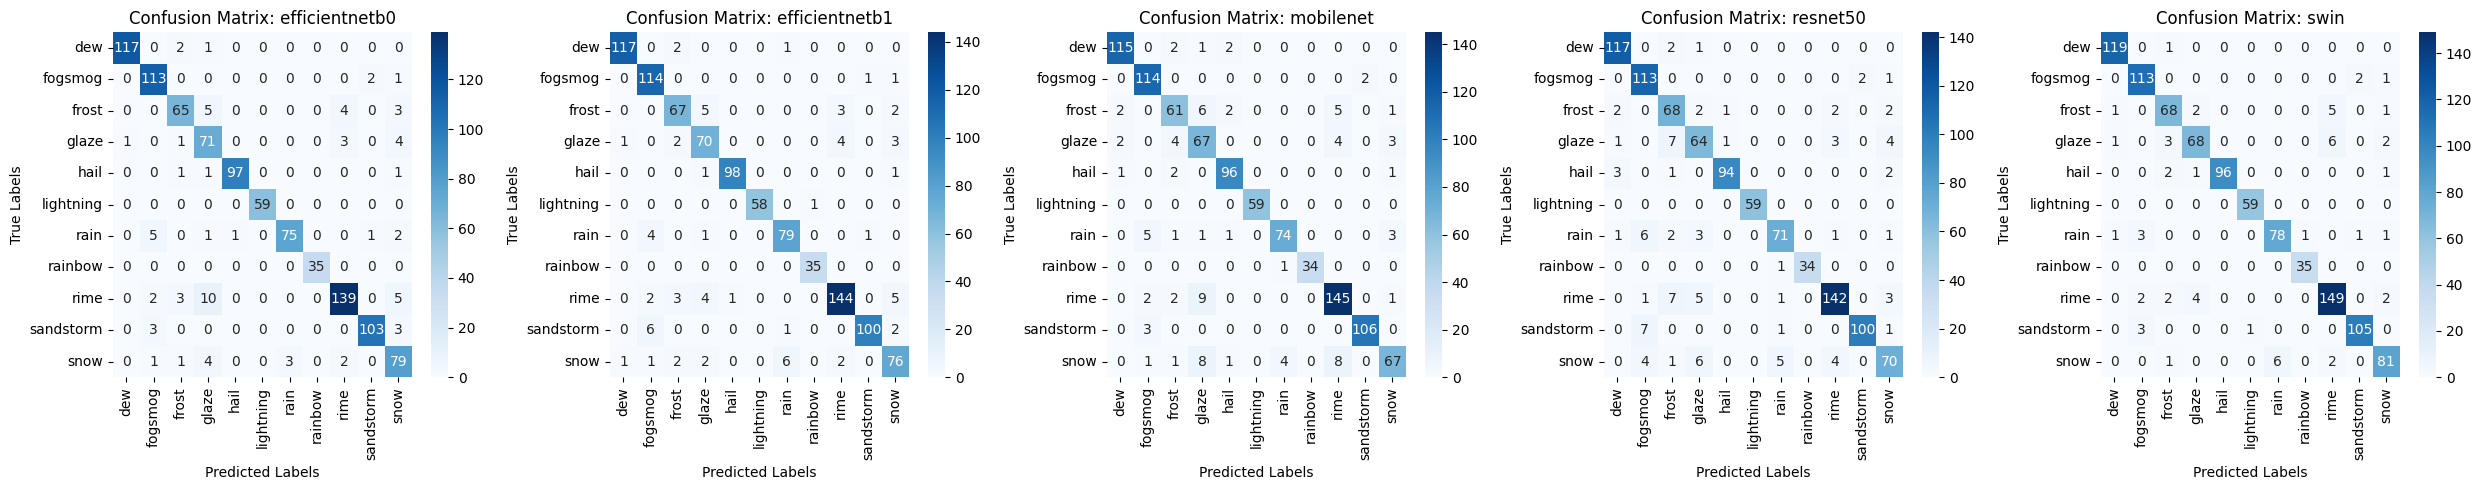

In [10]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, len(model_predictions), figsize=(len(model_predictions) * 5, 5))

if len(model_predictions) == 1:  # Handle single model case
    axes = [axes]

for ax, (model_name, y_pred) in zip(axes, model_predictions.items()):
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f"Confusion Matrix: {model_name}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

plt.tight_layout()
plt.show()

Showing misclassified samples for efficientnetb0...


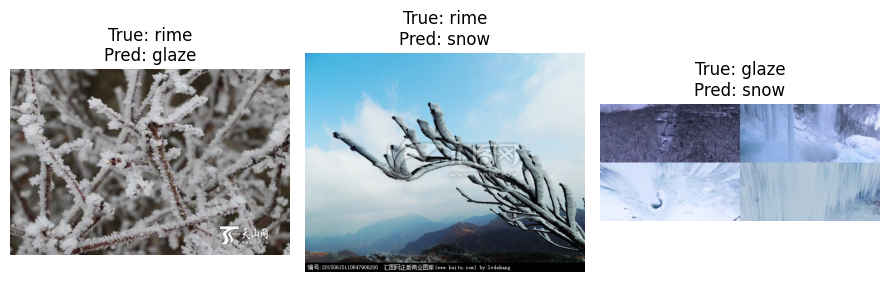

Showing misclassified samples for efficientnetb1...


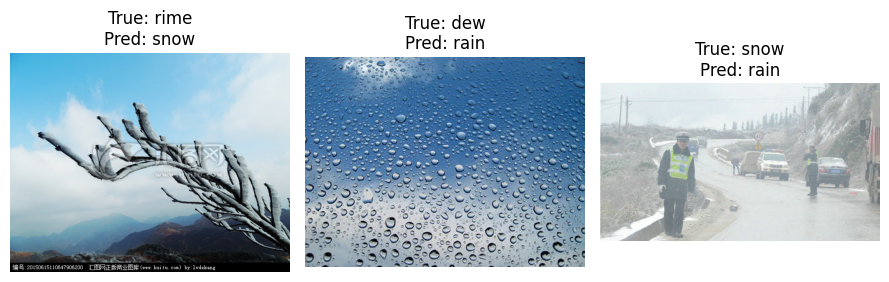

Showing misclassified samples for mobilenet...


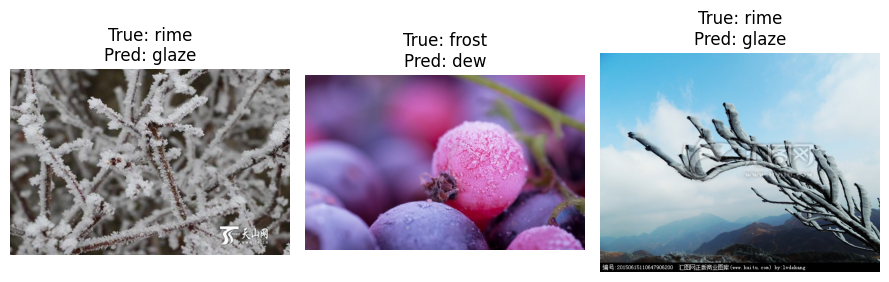

Showing misclassified samples for resnet50...


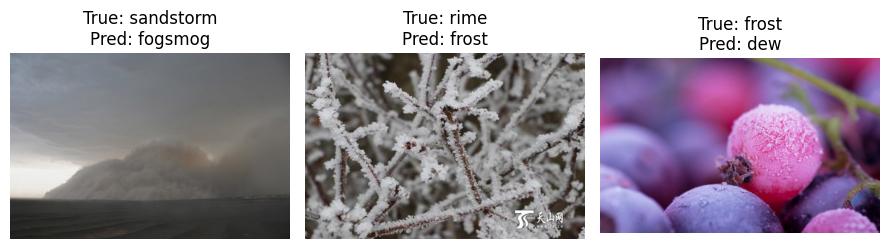

Showing misclassified samples for swin...


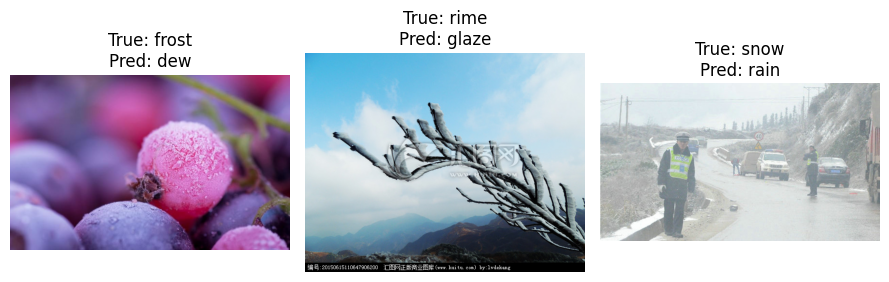

In [14]:
# show examples of missclassified images in notebook
def show_misclassified_samples(dataloader, y_true, y_pred, num_samples=3):
    misclassified_indices = np.where(y_true != y_pred)[0]
    num_samples = min(num_samples, len(misclassified_indices))
    
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    
    for i, idx in enumerate(misclassified_indices[:num_samples]):
        img = dataloader.dataset[idx][0]
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}", fontsize=12)
    
    plt.tight_layout()
    plt.show()

y_true_np = y_true.numpy()
dataset = WeatherDataModule(dataset_path, 32, 1, None, None)
dataset.setup()
test_dataloader = dataset.test_dataloader()
for model_name, y_pred in model_predictions.items():
    print(f"Showing misclassified samples for {model_name}...")
    show_misclassified_samples(test_dataloader, y_true_np, y_pred, num_samples=3)
